# MIE 1513 Assignment - Sentiment Analysis

In [1]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data loading

In [3]:
#Read in from pandas
hotelDf = pd.read_csv('reviews4.csv')
hotelDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']
hotelDf.head()

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,531560410,data4\ca\154913\10259142\535933244.html,Element Calgary Airport,I really enjoyed my stay here. The room had a ...,5,positive
1,535933244,data4\ca\154913\10259142\537074672.html,Element Calgary Airport,We stayed one night in this new hotel and it's...,5,positive
2,537074672,data4\ca\154913\10259142\538137131.html,Element Calgary Airport,Stayed at this hotel for business trip purpose...,5,positive
3,538137131,data4\ca\154913\10259142\540014523.html,Element Calgary Airport,Very clean. Modern and bright. GREAT mattress ...,4,positive
4,504192408,data4\ca\154913\10276193\504653214.html,Hilton Garden Inn Calgary Downtown,My partner and I and another couple stayed in ...,4,positive


In [53]:
hotelDf.shape

(3611, 6)

In [5]:
hotelDf = hotelDf.dropna().reset_index(drop=True)
hotelDf['reviewColumn'].notnull().values.any()

True

In [63]:
hotelDf.shape

(3418, 6)

### Sentiment Analysis setup

In [4]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(str(sentence))
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [5]:
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
reviewDF.head()

100%|█████████████████████████████████████████████████████████| 3611/3611 [00:09<00:00, 392.55it/s]


,reviewCol,vader
0,I really enjoyed my stay here. The room had a ...,0.9701
1,We stayed one night in this new hotel and it's...,0.9939
2,Stayed at this hotel for business trip purpose...,0.9530
3,Very clean. Modern and bright. GREAT mattress ...,0.9090
4,My partner and I and another couple stayed in ...,0.8108


In [59]:
reviewDF['reviewCol'].notnull().values.any()

True

In [60]:
reviewDF.shape

(3418, 2)

### Data Preprocessing
1. Find Topk words (No preprocessing steps now)
2. Reconstruct the above dataframe into CSV style..

In [6]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))

    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', str(review)) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',str(reviews[i]))])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [7]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=50)

In [70]:
#finaldf = finaldf[pd.notnull(finaldf['reviewCol'])]
finaldf['reviewCol'].notnull().values.any()

True

In [71]:
finaldf

,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,room,staff,stay,great,...,check,bathroom,excellent,even,beds,back,hot,day,two,floor
0,Element Calgary Airport,5,positive,I really enjoyed my stay here. The room had a ...,0.9701,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Element Calgary Airport,5,positive,We stayed one night in this new hotel and it's...,0.9939,1,1,1,0,1,...,1,1,0,1,0,0,0,0,0,0
2,Element Calgary Airport,5,positive,Stayed at this hotel for business trip purpose...,0.9530,1,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,Element Calgary Airport,4,positive,Very clean. Modern and bright. GREAT mattress ...,0.9090,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Hilton Garden Inn Calgary Downtown,4,positive,My partner and I and another couple stayed in ...,0.8108,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Hilton Garden Inn Calgary Downtown,2,negative,Checked in Sept 7. Nice King room. We unpacked...,0.7048,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
6,Hilton Garden Inn Calgary Downtown,4,positive,Stayed here for 3 nights. Overall this modern ...,0.8484,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Hilton Garden Inn Calgary Downtown,4,positive,First time at this hotel and had a very comfor...,0.8655,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,Hilton Garden Inn Calgary Downtown,5,positive,"We had a great stay, clean room and had fun wa...",0.9483,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,Hilton Garden Inn Calgary Downtown,5,positive,Room and amenities were brilliant as was the g...,0.9001,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

## Q1. Sentiment Analysis and Aggregation

**1 - a)** Compute average Vader sentiment and average ground truth rating per hotel.

In [9]:
#Extract a list of hotels
hotelNames = hotelDf['hotelName'].unique()
len(hotelNames)

70

In [10]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [11]:
#reviews_df.groupby(['hotelName'])['ratingScore'].mean()
hotelRating_Gt_df = getHotelRank(finaldf)

In [12]:
#reviews_df.groupby(['hotelName'])['vader'].mean()
hotelRating_Vd_df = getHotelRank(finaldf, measure='vader')

In [77]:
hotelRating_Gt_df

,hotelName,avgRatingScore
63,Hotel Elan,4.904762
43,Calgary Marriott Downtown Hotel,4.763636
0,Element Calgary Airport,4.750000
58,Residence Inn by Marriott Calgary Airport,4.710526
9,Hotel Le Germain Calgary,4.657407
54,Best Western Premier Freeport Inn & Suites,4.621622
59,Courtyard by Marriott Calgary Airport,4.615385
15,Best Western Plus Port O\'Call Hotel,4.564706
55,Hampton Inn & Suites By Hilton Calgary- Univer...,4.539394
66,Homewood Suites by Hilton Calgary-Airport,4.538462


In [78]:
hotelRating_Vd_df 

,hotelName,avgRatingScore
28,Sheraton Cavalier Hotel,0.962738
0,Element Calgary Airport,0.956500
58,Residence Inn by Marriott Calgary Airport,0.942253
57,Wingate by Wyndham Calgary South,0.939400
63,Hotel Elan,0.934190
19,Hotel Blackfoot,0.926823
2,Homewood Suites by Hilton Calgary Downtown,0.924918
49,Calgary North Thriftlodge,0.913062
59,Courtyard by Marriott Calgary Airport,0.912434
25,Aloft Calgary University,0.894879


**1 - b)** Rank hotels by
 * Average Ground Truth Sentiment
 * Average Vader Compound Sentiment Score
 
Show both top-5 and bottom-5 for both ranking methods. Do they agree or are there interesting
differences?

In [79]:
hotelRating_Gt_df.head()

,hotelName,avgRatingScore
63,Hotel Elan,4.904762
43,Calgary Marriott Downtown Hotel,4.763636
0,Element Calgary Airport,4.750000
58,Residence Inn by Marriott Calgary Airport,4.710526
9,Hotel Le Germain Calgary,4.657407


In [80]:
hotelRating_Vd_df.head()

,hotelName,avgRatingScore
28,Sheraton Cavalier Hotel,0.962738
0,Element Calgary Airport,0.956500
58,Residence Inn by Marriott Calgary Airport,0.942253
57,Wingate by Wyndham Calgary South,0.939400
63,Hotel Elan,0.934190


In [81]:
hotelRating_Gt_df.tail()

,hotelName,avgRatingScore
34,Ramada Plaza Calgary Airport Hotel and Confere...,2.300000
46,Super 8 Village Calgary AB,2.296296
50,Travelodge Hotel Calgary International Airport...,2.038462
51,Travelodge Hotel Calgary Macleod Trail,1.655172
45,Ramada Limited Calgary Northwest,1.541667


In [82]:
hotelRating_Vd_df.tail()

,hotelName,avgRatingScore
24,Canadas Best Value Inn Chinook Station,0.189503
50,Travelodge Hotel Calgary International Airport...,0.149737
21,Coast Plaza Hotel & Conference Centre,0.114663
45,Ramada Limited Calgary Northwest,-0.127279
51,Travelodge Hotel Calgary Macleod Trail,-0.165507


In [13]:
Ranking_summary_df = pd.DataFrame()
Ranking_summary_df["Ground Truth Top 5"] = hotelRating_Gt_df.head()["hotelName"].values
Ranking_summary_df["Vader Compound Top 5"] = hotelRating_Vd_df.head()["hotelName"].values
Ranking_summary_df["Ground Truth Bottom 5"] = hotelRating_Gt_df.tail()["hotelName"].values
Ranking_summary_df["Vader Compound Bottom 5"] = hotelRating_Vd_df.tail()["hotelName"].values

In [14]:
Ranking_summary_df

,Ground Truth Top 5,Vader Compound Top 5,Ground Truth Bottom 5,Vader Compound Bottom 5
0,Hotel Elan,Sheraton Cavalier Hotel,Canadas Best Value Inn Chinook Station,Travelodge Hotel Calgary International Airport...
1,Calgary Marriott Downtown Hotel,Element Calgary Airport,Super 8 Village Calgary AB,Super 8 Village Calgary AB
2,Element Calgary Airport,Residence Inn by Marriott Calgary Airport,Travelodge Hotel Calgary International Airport...,Coast Plaza Hotel & Conference Centre
3,Residence Inn by Marriott Calgary Airport,Wingate by Wyndham Calgary South,Travelodge Hotel Calgary Macleod Trail,Ramada Limited Calgary Northwest
4,Hotel Le Germain Calgary,Hotel Blackfoot,Ramada Limited Calgary Northwest,Travelodge Hotel Calgary Macleod Trail


**TOP 5: 2/5 MATCH (DIFFERENT ORDER)**<BR>
**BOTTOM 5: 2/5 MATCH ( LAST 2)**

## Q2. Frequency Analysis

**Top K words comparison between ground truth reviews and vader predicted reviews**

**2 - a)** Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth
sentiment to rank the top-50 most frequent non-stopwords in the review collection. Do you
note anything interesting and/or locale-specific about these top-ranked words?

In [15]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', str(review)) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [16]:
# Ground Truth positive or negative
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')

In [87]:
topkGroundPos

[('great', 1698),
 ('good', 1315),
 ('calgary', 1295),
 ('clean', 1153),
 ('breakfast', 1104),
 ('nice', 1082),
 ('would', 966),
 ('stayed', 883),
 ('friendly', 854),
 ('service', 853),
 ('comfortable', 827),
 ('well', 819),
 ('one', 784),
 ('location', 713),
 ('airport', 641),
 ('pool', 611),
 ('night', 605),
 ('helpful', 587),
 ('downtown', 553),
 ('restaurant', 548),
 ('also', 536),
 ('bed', 533),
 ('desk', 512),
 ('area', 512),
 ('front', 510),
 ('time', 505),
 ('excellent', 495),
 ('really', 493),
 ('free', 483),
 ('food', 480),
 ('close', 462),
 ('parking', 450),
 ('get', 417),
 ('place', 415),
 ('beds', 410),
 ('like', 390),
 ('check', 386),
 ('bathroom', 381),
 ('could', 372),
 ('modern', 365),
 ('recommend', 359),
 ('business', 357),
 ('restaurants', 356),
 ('large', 347),
 ('best', 340),
 ('definitely', 336),
 ('hot', 334),
 ('back', 330),
 ('two', 323),
 ('quiet', 320)]

In [88]:
topkGroundNeg

[('would', 454),
 ('one', 365),
 ('night', 350),
 ('good', 327),
 ('desk', 303),
 ('stayed', 289),
 ('breakfast', 284),
 ('front', 271),
 ('get', 269),
 ('clean', 267),
 ('bed', 251),
 ('like', 234),
 ('calgary', 225),
 ('could', 218),
 ('even', 216),
 ('time', 209),
 ('nice', 208),
 ('place', 195),
 ('service', 193),
 ('location', 175),
 ('back', 173),
 ('well', 172),
 ('great', 171),
 ('pool', 169),
 ('next', 167),
 ('also', 165),
 ('bathroom', 165),
 ('check', 164),
 ('got', 163),
 ('floor', 162),
 ('told', 158),
 ('day', 158),
 ('door', 145),
 ('free', 143),
 ('booked', 143),
 ('never', 141),
 ('really', 140),
 ('first', 140),
 ('parking', 136),
 ('area', 135),
 ('small', 134),
 ('two', 133),
 ('price', 133),
 ('morning', 131),
 ('airport', 129),
 ('hot', 128),
 ('friendly', 127),
 ('said', 127),
 ('went', 125),
 ('food', 121)]

**Positive: Many words in topkGroundPos are positive such as great, good, clean, nice, friendly (high ranked). The locate-specific words includes Calgary, airport, downtown, resuaurant, implying some degree of accessibility.**

**Negative: More nouns in the list, adjs are like old, some positive words are in the negatigve list. So maybe frequency is not a good measure for the sentiment. Some negative reviews will include goood points in the beginning but ends up with complaining.**

**2 - b)** Repeat this analysis for the top-50 noun phrases and note any interesting results.

In [17]:
tagger = PerceptronTagger()
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag

In [18]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [19]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [20]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [21]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [22]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', str(review))))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',str(reviews[i])))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [23]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF)

In [24]:
topk_phrase

[('front desk', 288),
 ('hot tub', 145),
 ('front desk staff', 127),
 ('downtown calgari', 97),
 ('hotel art', 84),
 ('great locat', 71),
 ('hotel room', 69),
 ('calgari tower', 66),
 ('room servic', 61),
 ('next morn', 61),
 ('comfort bed', 60),
 ('continent breakfast', 59),
 ('breakfast buffet', 57),
 ('next day', 57),
 ('great place', 56),
 ('hotel staff', 56),
 ('free breakfast', 54),
 ('next time', 51),
 ('pool area', 50),
 ('friendli staff', 50),
 ('good locat', 49),
 ('night stay', 48),
 ('great hotel', 47),
 ('first time', 44),
 ('good valu', 43),
 ('calgari airport', 38),
 ('busi trip', 38),
 ('park lot', 37),
 ('clean room', 37),
 ('great stay', 36),
 ('credit card', 35),
 ('nice touch', 35),
 ('busi travel', 35),
 ('le germain', 34),
 ('water slide', 34),
 ('easi access', 34),
 ('nice hotel', 33),
 ('calgari stamped', 33),
 ('custom servic', 33),
 ('good hotel', 32),
 ('first night', 32),
 ('complimentari breakfast', 31),
 ('bedroom suit', 30),
 ('queen bed', 30),
 ('clean s

In [25]:
def getTopK_phrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    reviews = df.loc[operation(df[label_column],label_value)][value_column]
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', str(review))))) 
                            ]))
    topk = counter.most_common(k)
    return topk

In [26]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf_phrase = finaldf_phrase[['reviewCol','groundTruth','vader']]

In [27]:
topkGroundPos_phase = getTopK_phrase(df=itemAnalysisDf_phrase, k=50, label_value='positive')
topkGroundNeg_phase = getTopK_phrase(df=itemAnalysisDf_phrase, k=50, label_value='negative')

In [28]:
topkGroundPos_phase

[('front desk', 171),
 ('hot tub', 103),
 ('front desk staff', 95),
 ('downtown calgari', 87),
 ('hotel art', 81),
 ('calgari tower', 63),
 ('great locat', 59),
 ('comfort bed', 57),
 ('breakfast buffet', 51),
 ('great place', 51),
 ('great hotel', 47),
 ('room servic', 47),
 ('hotel staff', 46),
 ('friendli staff', 45),
 ('hotel room', 45),
 ('pool area', 43),
 ('next time', 43),
 ('free breakfast', 42),
 ('good valu', 40),
 ('good locat', 39),
 ('continent breakfast', 39),
 ('great stay', 35),
 ('night stay', 34),
 ('le germain', 33),
 ('calgari airport', 33),
 ('first time', 33),
 ('next morn', 33),
 ('nice touch', 32),
 ('busi trip', 31),
 ('calgari stamped', 30),
 ('nice hotel', 29),
 ('water slide', 28),
 ('easi access', 28),
 ('busi travel', 28),
 ('complimentari breakfast', 26),
 ('bedroom suit', 26),
 ('next day', 26),
 ('hotel restaur', 25),
 ('good hotel', 25),
 ('minut walk', 25),
 ('clean room', 25),
 ('shuttl servic', 24),
 ('good size', 24),
 ('free shuttl', 24),
 ('grea

In [29]:
topkGroundNeg_phase

[('front desk', 117),
 ('hot tub', 42),
 ('front desk staff', 32),
 ('next day', 31),
 ('next morn', 28),
 ('credit card', 28),
 ('hotel room', 24),
 ('continent breakfast', 20),
 ('differ room', 18),
 ('hot water', 18),
 ('park lot', 17),
 ('non smoke room', 17),
 ('air condition', 14),
 ('night stay', 14),
 ('room servic', 14),
 ('sever time', 13),
 ('great locat', 12),
 ('free breakfast', 12),
 ('clean room', 12),
 ('star hotel', 12),
 ('first night', 12),
 ('first time', 11),
 ('comfort inn', 11),
 ('desk clerk', 11),
 ('long time', 10),
 ('phone call', 10),
 ('second floor', 10),
 ('downtown calgari', 10),
 ('custom servic', 10),
 ('smoke room', 10),
 ('new room', 10),
 ('good locat', 10),
 ('hotel staff', 10),
 ('second time', 9),
 ('hampton inn', 9),
 ('coffe maker', 9),
 ('second night', 9),
 ('last night', 9),
 ('room rate', 9),
 ('holiday inn', 9),
 ('sofa bed', 8),
 ('next time', 8),
 ('air condit', 8),
 ('stamped week', 8),
 ('queen bed', 8),
 ('airport hotel', 8),
 ('clean

**Positive: Similarly, phrase in topkGroundPos includes most of postive words, noun phrase such as great location, comfort bed, great view. Locate-specific phrase like downtown calgari, calgari airport.** 

**Negative: Some complaints contain most of facility phrases such as hot tub and wifi, implying an expectation of improvment.**

**front desk is the most mentioned NP for both positive and negative comments.** 

## Q3. Mutual Information

**3 - a)** Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentimentbearing
non-stopwords in the review collection. Do you note anything interesting and/or
locale-specific about these top-ranked words?

In [30]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word/Phase','MI Score']
    return miScoredf

In [31]:
miScoredf = getMI(topk, finaldf)

In [32]:
miScoredf

,Word/Phase,MI Score
4,great,0.028314
2,staff,0.014692
42,excellent,0.013663
18,comfortable,0.012570
29,helpful,0.010450
16,friendly,0.010375
6,calgary,0.008732
27,get,0.005769
43,even,0.005734
17,night,0.005671


**Mostly the adjectives are more positive, implying customers tent to write more when having good experience. top ranked words includes carglary, many reviews mentioned this location - more hotels in carglary in the dataset.**

**3 - b)** Repeat this analysis for the top-50 noun phrases and note any interesting results.

In [33]:
miScoredf_phrase = getMI(topk_phrase, finaldf_phrase)

In [34]:
miScoredf_phrase

,Word/Phase,MI Score
30,credit card,0.005328
0,front desk,0.004030
22,great hotel,0.003486
4,hotel art,0.003067
13,next day,0.002891
7,calgari tower,0.002439
10,comfort bed,0.002133
46,hot water,0.002056
9,next morn,0.001817
29,great stay,0.001726


**the list has a lot of nouns such as next day, implying a strong negative expereinces. Normally positive experiences comes with positive adj- noun phrases. Locate-specific phrases: carglary tower - must be the signiture place in calglary.**

## Q4. Pointwise Mutual Information

**4 - a)** For ground truth sentiment, calculate the top-50 words according to PMI of the word occuring
with (i) positive reviews and (ii) negative reviews. Do you note anything interesting and/or
locale-specific about these top-ranked words?

In [35]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            #probability of x and y
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            # joint probability
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                # point wise mutual information
                pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

# https://en.wikipedia.org/wiki/Mutual_information

In [36]:
# Simple example of getting pairwise mutual information of a term
def pmiCal2(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            #probability of x and y
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            # joint probability
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                # point wise mutual information
                pmi = math.log((pxy+0.0001)/(px*py+0.0001))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

# https://en.wikipedia.org/wiki/Mutual_information

In [37]:
pmiCal(finaldf,'great')

,x,y,px,py,pxy,pmi
0,positive,0,0.766547,0.641374,0.445583,-0.098369
1,positive,1,0.766547,0.358626,0.320964,0.154907
2,negative,0,0.233453,0.641374,0.195791,0.268207
3,negative,1,0.233453,0.358626,0.037663,-0.798838


In [38]:
pmiCal2(finaldf,'great')

,x,y,px,py,pxy,pmi
0,positive,0,0.766547,0.641374,0.445583,-0.098369
1,positive,1,0.766547,0.358626,0.320964,0.154907
2,negative,0,0.233453,0.641374,0.195791,0.268207
3,negative,1,0.233453,0.358626,0.037663,-0.798838


In [39]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [40]:
def pmiIndivCal2(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py+0.0001))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [41]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word/phrase','pmi']
    pmineglist.columns = ['word/phrase','pmi']
    pmidf.columns = ['word/phrase','pmi']
    return pmiposlist, pmineglist, pmidf

In [42]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal2(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal2(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal2(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal2(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word/phrase','pmi']
    pmineglist.columns = ['word/phrase','pmi']
    pmidf.columns = ['word/phrase','pmi']
    return pmiposlist, pmineglist, pmidf

In [43]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.72it/s]


In [44]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
42,excellent,0.193919
4,great,0.154907
29,helpful,0.150868
18,comfortable,0.137400
16,friendly,0.123181
31,downtown,0.115037
6,calgary,0.098491
2,staff,0.095762
11,nice,0.086257
24,airport,0.084319


In [45]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
43,even,0.449251
34,like,0.396746
27,get,0.390245
49,floor,0.356161
37,could,0.354093
17,night,0.330114
20,desk,0.326448
47,day,0.272659
41,bathroom,0.266679
22,front,0.262447


**Similar findings: more positive adj; location: calgary, downtown, airport, restaurant. Negative: nouns like night, floor, day; location: parking, pool.**

**4 - b)** Repeat this analysis for the top-50 noun phrases and note any interesting results.

In [46]:
pmiposlist_phrase, pmineglist_phrase, pmidf_phrase = pmiForAllCal(finaldf_phrase, topk = topk_phrase)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.20it/s]


In [47]:
#Sorted top pmi words for positive reviews
pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
22,great hotel,0.265860
29,great stay,0.237689
33,le germain,0.230768
4,hotel art,0.225038
7,calgari tower,0.218607
10,comfort bed,0.214566
24,good valu,0.193539
48,minut walk,0.182478
31,nice touch,0.176248
14,great place,0.172334


In [48]:
#Sorted top pmi words for negative reviews
pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
30,credit card,1.213611
46,hot water,0.958336
13,next day,0.797994
27,park lot,0.732638
9,next morn,0.652427
0,front desk,0.479059
40,first night,0.418681
11,continent breakfast,0.373860
6,hotel room,0.340412
28,clean room,0.328762


In [58]:
pmiCal(finaldf_phrase,'credit card')

,x,y,px,py,pxy,pmi
0,positive,0,0.766547,0.992246,0.764885,0.005614
1,positive,1,0.766547,0.007754,0.001662,-1.274585
2,negative,0,0.233453,0.992246,0.227361,-0.018660
3,negative,1,0.233453,0.007754,0.006092,1.213611


**Positive: noun phrases with positive adj. hotel name "le germain", "hotel art", tent to have more reviews - > positive. Location - calgary tower again.**

**Negative: nouns like credit card, hot water, next day - implying complaining and expectation.**

**4 - c)** Repeat this analysis for the single top and single bottom hotel (according to the ground
truth rating). Do you gain any useful hotel-specific insights about what is good and bad
about these two hotels? If not, explain why not.

In [49]:
Ranking_summary_df

,Ground Truth Top 5,Vader Compound Top 5,Ground Truth Bottom 5,Vader Compound Bottom 5
0,Hotel Elan,Sheraton Cavalier Hotel,Canadas Best Value Inn Chinook Station,Travelodge Hotel Calgary International Airport...
1,Calgary Marriott Downtown Hotel,Element Calgary Airport,Super 8 Village Calgary AB,Super 8 Village Calgary AB
2,Element Calgary Airport,Residence Inn by Marriott Calgary Airport,Travelodge Hotel Calgary International Airport...,Coast Plaza Hotel & Conference Centre
3,Residence Inn by Marriott Calgary Airport,Wingate by Wyndham Calgary South,Travelodge Hotel Calgary Macleod Trail,Ramada Limited Calgary Northwest
4,Hotel Le Germain Calgary,Hotel Blackfoot,Ramada Limited Calgary Northwest,Travelodge Hotel Calgary Macleod Trail


In [50]:
hotel_top = "Hotel Le Germain Calgary"
hotel_bottom = "Travelodge Hotel Calgary Macleod Trail"

In [51]:
finaldf_top = finaldf[finaldf['hotelName']==hotel_top]
finaldf_bot = finaldf[finaldf['hotelName']==hotel_bottom]

In [52]:
finaldf_top

,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,room,staff,stay,great,...,check,bathroom,excellent,even,beds,back,hot,day,two,floor
400,Hotel Le Germain Calgary,5,positive,My wife booked us a luxury room as a short get...,0.9831,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
401,Hotel Le Germain Calgary,5,positive,I was traveling with my fiance and we wanted t...,0.9976,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,0
402,Hotel Le Germain Calgary,4,positive,The hotel has an excellent location in the cen...,-0.1235,1,1,1,0,0,...,0,1,1,1,0,0,0,1,0,1
403,Hotel Le Germain Calgary,5,positive,I never take the time to review a hotel so res...,0.9990,1,1,0,1,1,...,0,1,0,1,0,1,0,0,1,1
404,Hotel Le Germain Calgary,5,positive,We loved the location of the hotel right down ...,0.9946,1,1,1,1,0,...,0,0,0,1,1,0,0,0,0,0
405,Hotel Le Germain Calgary,4,positive,We enjoyed 5 days in a beautiful room at le Ge...,0.9854,1,1,1,0,0,...,0,1,0,0,1,0,1,0,0,0
406,Hotel Le Germain Calgary,5,positive,We had heard great things about this hotel pri...,0.9966,1,1,1,1,1,...,0,1,0,1,0,1,0,1,0,1
407,Hotel Le Germain Calgary,5,positive,We stayed at Le Germain Calgary for four night...,0.9911,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
408,Hotel Le Germain Calgary,5,positive,We had a wonderful hotel stay! Our room was lo...,0.9622,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
409,Hotel Le Germain Calgary,3,negative,"Stayed there this past weekend. Good ambiance,...",0.9231,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [53]:
pmiposlist_top, pmineglist_top, pmidf_top = pmiForAllCal2(finaldf_top)
pmiposlist_bot, pmineglist_bot, pmidf_bot = pmiForAllCal2(finaldf_bot)

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.96it/s]


In [54]:
#Sorted top pmi words for positive reviews
pmiposlist_top.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
47,day,0.046957
33,free,0.046957
29,helpful,0.046957
23,pool,0.046957
44,beds,0.046957
16,friendly,0.046957
24,airport,0.046957
18,comfortable,0.033164
41,bathroom,0.030428
2,staff,0.022264


In [55]:
#Sorted top pmi words for negative reviews
pmineglist_top.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
49,floor,1.184790
48,two,1.067007
46,hot,0.884685
35,place,0.848318
25,time,0.830618
26,also,0.684015
37,could,0.569604
17,night,0.542936
27,get,0.373860
8,clean,0.373860


In [56]:
#Sorted top pmi words for positive reviews
pmiposlist_bot.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
28,restaurant,2.335375
5,good,2.047693
23,pool,1.642228
42,excellent,1.642228
6,calgary,1.642228
18,comfortable,1.642228
16,friendly,1.642228
14,service,1.236763
29,helpful,1.236763
38,parking,1.236763


In [57]:
#Sorted top pmi words for negative reviews
pmineglist_bot.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
47,day,0.101783
46,hot,0.101783
4,great,0.101783
44,beds,0.101783
39,close,0.101783
36,food,0.101783
35,place,0.101783
33,free,0.101783
26,also,0.101783
19,location,0.101783


 * **PMI = 0: log(pxy/px*py) = 0, pxy = px * py, the feature(word) can only appear in the target, eg: "great" only appears in "positive" target, then PMI("great") in positive group is 0.**
 * **PMI is a large negative number, we having PMI = log((pxy+0.0001)/px*py), large negative PMI implys a small number of (pxy+0.0001)/px*py, implys a 0 in pxy, below table is an example. --> word does not appear in the positive reviews.**

In [59]:
pmiCal(finaldf_bot,'restaurant')

,x,y,px,py,pxy,pmi
0,positive,0,0.096774,0.967742,0.064516,-0.372675
1,positive,1,0.096774,0.032258,0.032258,2.335375
2,negative,0,0.903226,0.967742,0.903226,0.032790
3,negative,1,0.903226,0.032258,0.000000,-5.674570


In [60]:
pmiCal(finaldf_bot,'place')

,x,y,px,py,pxy,pmi
0,positive,0,0.096774,0.774194,0.096774,0.255933
1,positive,1,0.096774,0.225806,0.000000,-5.386888
2,negative,0,0.903226,0.774194,0.677419,-0.031749
3,negative,1,0.903226,0.225806,0.225806,0.101783


## Q5. General Plots

### 5.1 Histogram

**5.1 - a)** Show separate histograms of ground truth and Vader sentiment scores (ignore hotel ID).
Do you notice any interesting differences?

In [130]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

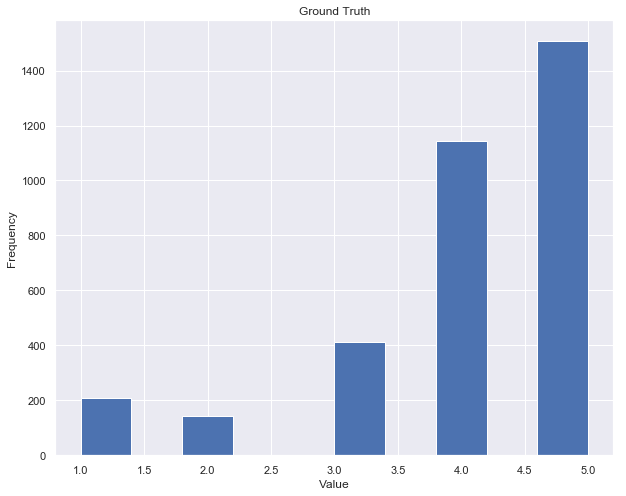

In [131]:
getHistogram('ratingScore', 'Ground Truth')

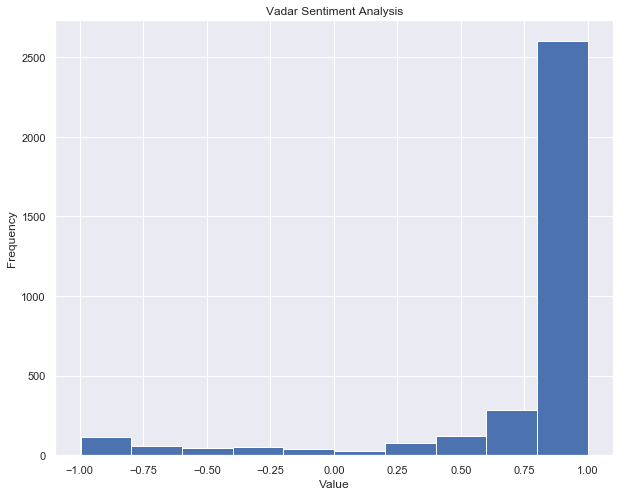

In [132]:
getHistogram('vader', 'Vadar Sentiment Analysis')

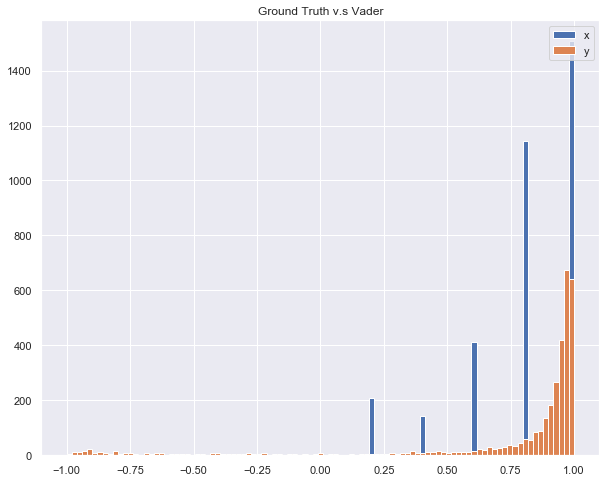

In [133]:
getHistogram('both', 'Ground Truth v.s Vader')

**trend, continuous difference. rating for 2 is lowest in star rating.**

**5.1 - b)** Show a histogram of the number of reviews per hotel. Do you notice any interesting
trends? Are these expected?

In [11]:
def getReviewNum(df):
    counter = Counter(df['hotelName'])   
    review_number_df = pd.DataFrame(list(counter.items()))
    review_number_df.columns=['hotelName', '#Reviews']
    review_number_df = review_number_df.sort_values('#Reviews',ascending=0)
    return review_number_df

In [17]:
bar_number

range(0, 70)

In [13]:
review_number_df = getReviewNum(finaldf)

In [14]:
hotel_list = review_number_df['hotelName'].tolist()
count_list = review_number_df['#Reviews'].tolist()

Text(0.5, 1.0, 'Distribution of the Reviews over All Hotels')

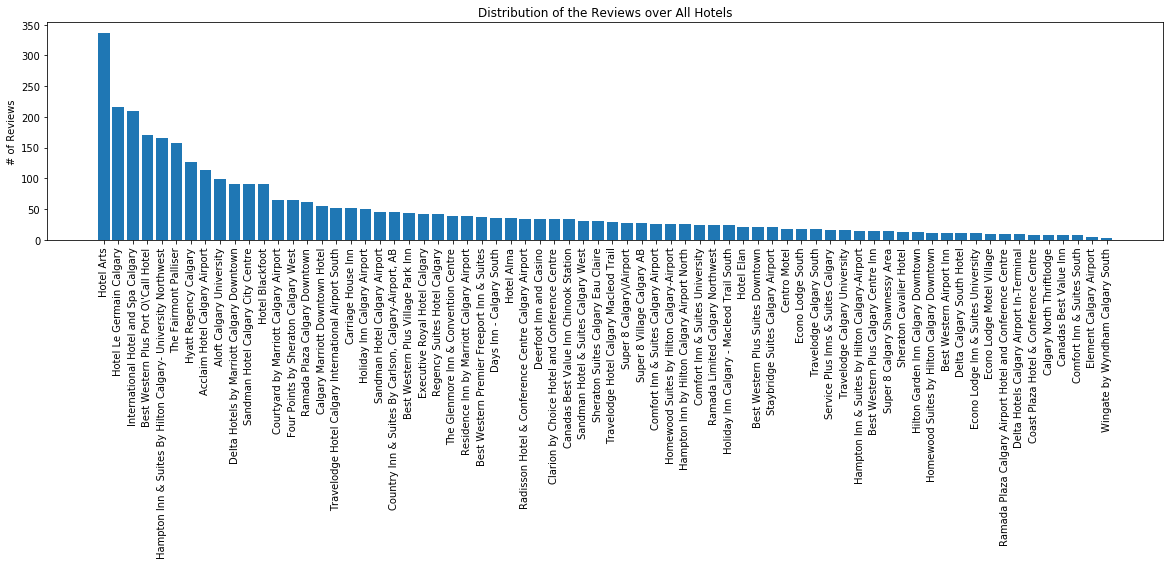

In [16]:
# plot a histogram
plt.figure(figsize=(20,4))
bar_number = range(len(hotelNames))
plt.bar(bar_number, count_list, align='center')
plt.xticks(bar_number, hotel_list, rotation = 90)
plt.ylabel('# of Reviews')
plt.title('Distribution of the Reviews over All Hotels')

In [145]:
review_number_df

,hotelName,# of Reviews
36,Hotel Arts,337
8,Hotel Le Germain Calgary,216
32,International Hotel and Spa Calgary,210
25,Best Western Plus Port O\'Call Hotel,170
3,Hampton Inn & Suites By Hilton Calgary- Univer...,165
45,The Fairmont Palliser,158
15,Hyatt Regency Calgary,127
18,Acclaim Hotel Calgary Airport,113
60,Aloft Calgary University,99
10,Delta Hotels by Marriott Calgary Downtown,91


**normally more number of ratings implys higher rating level, bias may lead by few but high ratings/ few but low ratings. Hotel Arts is visited the most.**

### 5.2 Boxplots

**5.2 - a)** In two plots, one for ground truth star rating and one for Vader sentiment, show a plot
of 5 side-by-side boxplots of these scores.

In [146]:
hotelRating_Gt_df.head()

,hotelName,avgRatingScore
63,Hotel Elan,4.904762
43,Calgary Marriott Downtown Hotel,4.763636
0,Element Calgary Airport,4.750000
58,Residence Inn by Marriott Calgary Airport,4.710526
9,Hotel Le Germain Calgary,4.657407


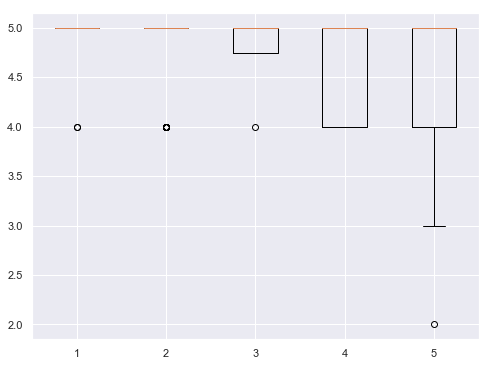

In [147]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRating_Gt_df.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

one = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
two = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
three = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
four = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
five = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [one,two,three,four,five]
# multiple box plots on one figure
plt.figure(figsize=(8,6))
plt.boxplot(data)
plt.show()

In [148]:
data

[3255    5
 3256    5
 3257    5
 3258    5
 3259    5
 3260    5
 3261    5
 3262    5
 3263    5
 3264    5
 3265    5
 3266    4
 3267    5
 3268    4
 3269    5
 3270    5
 3271    5
 3272    5
 3273    5
 3274    5
 3275    5
 Name: ratingScore, dtype: int64, 2365    4
 2366    5
 2367    5
 2368    5
 2369    4
 2370    5
 2371    4
 2372    5
 2373    4
 2374    4
 2375    5
 2376    5
 2377    5
 2378    4
 2379    5
 2380    4
 2381    5
 2382    5
 2383    5
 2384    4
 2385    5
 2386    5
 2387    5
 2388    5
 2389    5
 2390    5
 2391    5
 2392    5
 2393    5
 2394    5
 2395    5
 2396    5
 2397    5
 2398    5
 2399    5
 2400    5
 2401    5
 2402    5
 2403    5
 2404    5
 2405    4
 2406    5
 2407    4
 2408    5
 2409    4
 2410    5
 2411    5
 2412    5
 2413    5
 2414    5
 2415    4
 2416    5
 2417    4
 2418    5
 2419    5
 Name: ratingScore, dtype: int64, 0    5
 1    5
 2    5
 3    4
 Name: ratingScore, dtype: int64, 3031    5
 3032    5
 3033    4


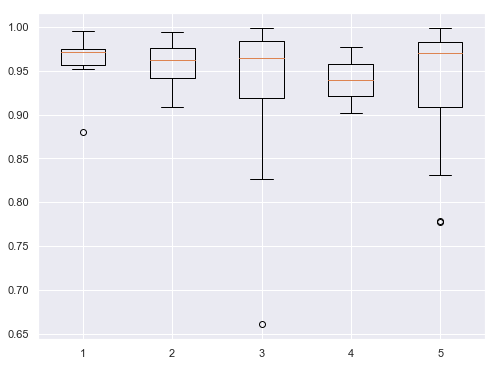

In [176]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel_v = hotelRating_Vd_df.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel_v['hotelName'].values

one_v = finaldf.loc[finaldf['hotelName'] == tp5gthotel_v['hotelName'].values[0]]['vader']
two_v = finaldf.loc[finaldf['hotelName'] == tp5gthotel_v['hotelName'].values[1]]['vader']
three_v = finaldf.loc[finaldf['hotelName'] == tp5gthotel_v['hotelName'].values[2]]['vader']
four_v = finaldf.loc[finaldf['hotelName'] == tp5gthotel_v['hotelName'].values[3]]['vader']
five_v = finaldf.loc[finaldf['hotelName'] == tp5gthotel_v['hotelName'].values[4]]['vader']

data_v = [one_v,two_v,three_v,four_v,five_v]
# multiple box plots on one figure
plt.figure(figsize=(8,6))
plt.boxplot(data_v)
plt.show()

In [150]:
data_v

[1364    0.8804
 1365    0.9513
 1366    0.9773
 1367    0.9718
 1368    0.9528
 1369    0.9686
 1370    0.9724
 1371    0.9710
 1372    0.9747
 1373    0.9566
 1374    0.9867
 1375    0.9570
 1376    0.9950
 Name: vader, dtype: float64, 0    0.9701
 1    0.9939
 2    0.9530
 3    0.9090
 Name: vader, dtype: float64, 3031    0.8979
 3032    0.9228
 3033    0.9831
 3034    0.9896
 3035    0.9099
 3036    0.9796
 3037    0.8965
 3038    0.9912
 3039    0.9664
 3040    0.6611
 3041    0.9946
 3042    0.8968
 3043    0.9985
 3044    0.9855
 3045    0.8268
 3046    0.9643
 3047    0.9476
 3048    0.8689
 3049    0.9708
 3050    0.9392
 3051    0.8953
 3052    0.9806
 3053    0.9479
 3054    0.9647
 3055    0.8566
 3056    0.9176
 3057    0.9302
 3058    0.9682
 3059    0.9712
 3060    0.9921
 3061    0.9960
 3062    0.9536
 3063    0.9537
 3064    0.9888
 3065    0.9558
 3066    0.9943
 3067    0.9843
 3068    0.9636
 Name: vader, dtype: float64, 3029    0.9022
 3030    0.9766
 Name: vader,

**5.2 - b)** Report the mean and variance of the ground truth and Vader sentiment scores for the
top-5 ranked hotels according to star rating.

In [151]:
top_hotel_Gt_mean = []
for i in range(len(data)):
    top_hotel_Gt_mean.append(np.array(data[i]).mean())

top_hotel_Gt_var = []
for i in range(len(data)):
    top_hotel_Gt_var.append(np.array(data[i]).var())

In [177]:
one_v2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['vader']
two_v2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['vader']
three_v2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['vader']
four_v2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['vader']
five_v2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['vader']

data_v2 = [one_v2,two_v2,three_v2,four_v2,five_v2]

In [178]:
top_hotel_v_mean = []
for i in range(len(data)):
    top_hotel_v_mean.append(np.array(data_v2[i]).mean())

top_hotel_v_var = []
for i in range(len(data)):
    top_hotel_v_var.append(np.array(data_v2[i]).var())

In [153]:
top_hotel_Gt_mean

[4.904761904761905,
 4.763636363636364,
 4.75,
 4.7105263157894735,
 4.657407407407407]

In [154]:
top_hotel_Gt_var

[0.08616780045351474,
 0.180495867768595,
 0.1875,
 0.20567867036011075,
 0.33633401920438966]

In [179]:
top_hotel_v_mean

[0.9341904761904761,
 0.8671181818181818,
 0.9564999999999999,
 0.9422526315789473,
 0.8729060185185186]

In [180]:
top_hotel_v_var

[0.0046105618140589565,
 0.05890666730578514,
 0.0009630549999999993,
 0.003932451966759003,
 0.08232286871377743]

Hotel | GT_Mean | GT_Variance | Vader_Mean| Vader_Variance
--- | --- | --- | --- | ---
top1 | 4.9091 | 0.0826 | 0.9342 | 0.0046
top2 | 4.7636 | 0.1805 | 0.8671 | 0.0489
top3 | 4.7500 | 0.1875 | 0.9565 | 0.0010
top4 | 4.7105 | 0.2057 | 0.9423 | 0.0039
top5 | 4.6559 | 0.3358 | 0.8729 | 0.0823

**5.2 - c)** Which do you find more informative, the boxplots or the mean and variance, or are they
equally informative? Why?

**box plot : visual, informative, having min, max, quantile, outliers**

### 5.3 Scatterplots and heatmaps


**5.3 - a)** Show both a scatterplot **and** heatmap of ground truth score (star rating) versus Vader
sentiment score. Each review is a point on the scatterplot. Do you notice anything
interesting? What does this tell you about star ratings vs. Vader sentiment scores?
What does this tell you about human ratings and/or Vader sentiment analysis?

Text(0.5, 0, 'Vader Score')

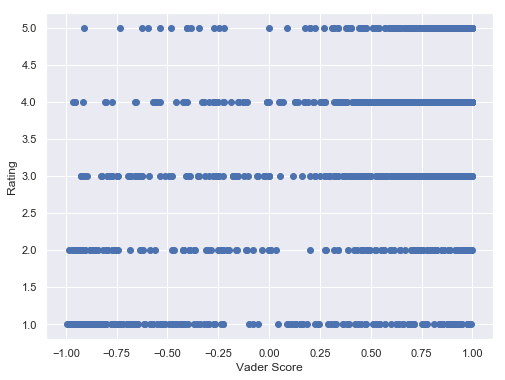

In [157]:
plt.figure(figsize=(8,6))
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [158]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

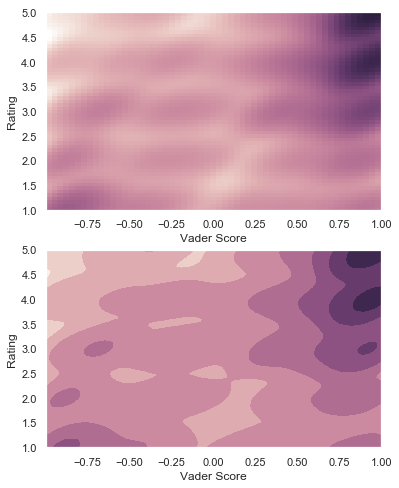

In [159]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

**vader and rating aline, and more number of ratings implys better ratings/vader.**

**5.3 - b)** Show two scatterplots **and** two heatmaps of the length of reviews versus each of ground
truth score and Vader sentiment score. Each review is a point on the scatterplot. Are
there any trends?


In [20]:
x=[]
list_temp = finaldf["reviewCol"].tolist()
for i in range(len(list_temp)):
    x.append(len(list_temp[i]))
x = np.asarray(x) 

Text(0.5, 0, 'Length of Review')

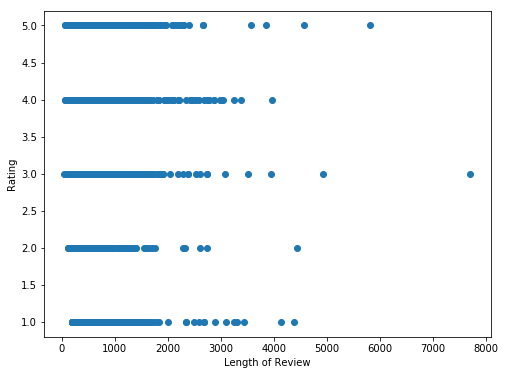

In [21]:
plt.figure(figsize=(8,6))
y = finaldf['ratingScore'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Length of Review')

In [162]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

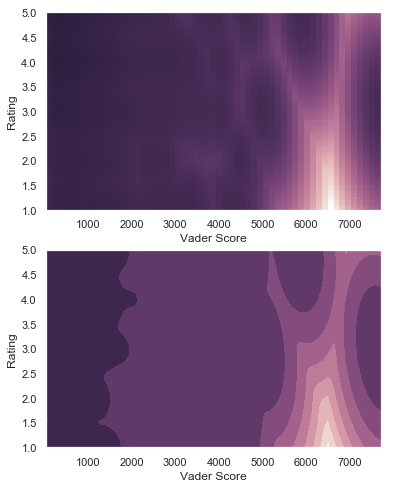

In [163]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

In [164]:
y = finaldf['vader'].values

Text(0.5, 0, 'Length of Review')

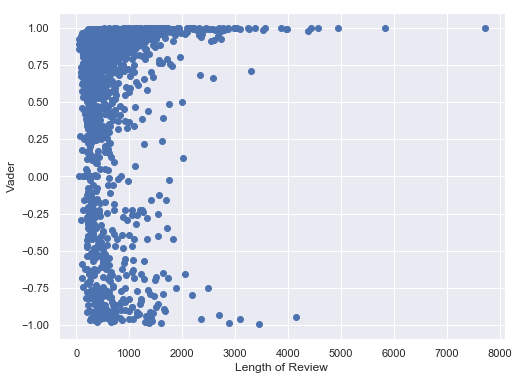

In [165]:
plt.figure(figsize=(8,6))
plt.plot(x, y,"o")
plt.ylabel('Vader')
plt.xlabel('Length of Review')

In [166]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0, 0.5, 'Rating')

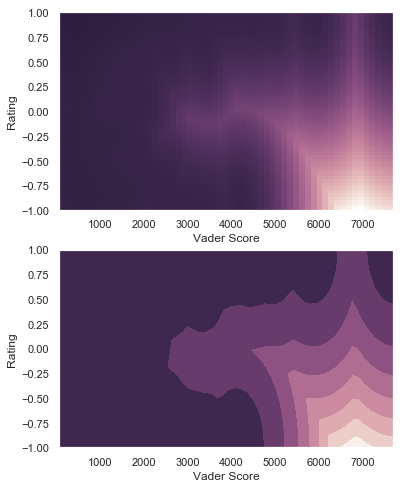

In [167]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

**for star rating: more you write, either good or bad experience. for vader, similar but more you write implys more about good experience.**

**5.3 - c)** Show two scatterplots of the number of reviews per hotel versus each of average ground
truth score and average Vader sentiment score. In this case, each hotel is a single point
on the scatterplot. Are there any trends?


In [22]:
merge_df = pd.merge(hotelRating_Gt_df, hotelRating_Vd_df, on='hotelName', how='outer')
#lastDf = hotelRating_Gt_df.merge(hotelRating_Vd_df)
#lastDf = lastDf.join(ReviewNumDf.set_index('hotelName'), on='hotelName')

NameError: name 'hotelRating_Gt_df' is not defined

In [170]:
merge_df = pd.merge(merge_df, review_number_df, on='hotelName', how='inner')

Text(0.5, 0, '# of Reviews')

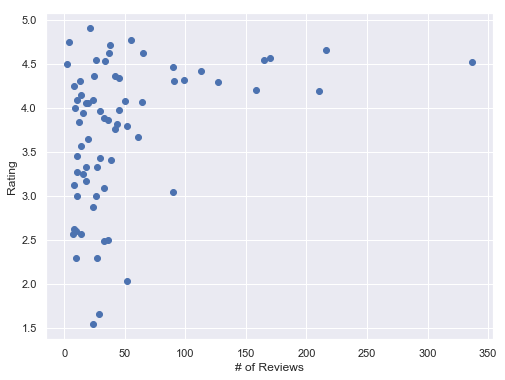

In [171]:
plt.figure(figsize=(8,6))
y = merge_df['avgRatingScore_x'].values
x = merge_df['# of Reviews'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('# of Reviews')

Text(0.5, 0, '# of Reviews')

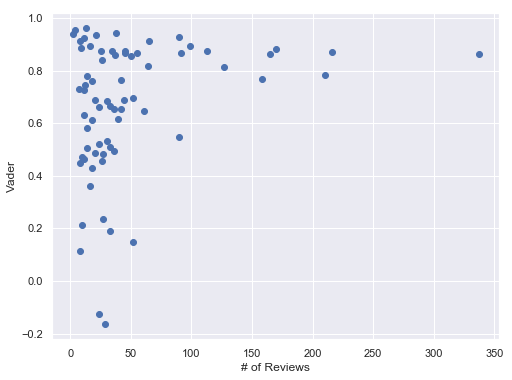

In [172]:
plt.figure(figsize=(8,6))
y = merge_df['avgRatingScore_y'].values
x = merge_df['# of Reviews'].values
plt.plot(x, y,"o")
plt.ylabel('Vader')
plt.xlabel('# of Reviews')

**more review numbers implys better experience.**